# Differentially Private Linear Regression
:label:`dp_linear_regression`

Linear regression is the single most commonly used statistical method for analyzing the relationships between variables. Even in the age of deep learning, linear regression still stand out in many applications in which interpretability is paramount. This is particularly true in sensitive domains where privacy is especially relevant. 

Recall that we covered a from-scratch implementation of linear regression as the very first model to introduce in the first volume of teh D2L book (see Section 3.4). In this notebook, we will how to make it differentially private using the basic DP mechanisms that we have learned earlier.

 
## We will consider two DP mechanisms for this task: 1. SSP 2. AdaSSP.

SSP stands for sufficient statistics perturbation. It is a simple algorithm that applies Gaussian mechanism to release both sufficient statistics of the linear regression problem: $X^TX$ and $X^Ty$.  

* The Gaussian mechanism for releasing $X^TX$ with a symmetric noise matrix known as `AnalyzeGauss`, which ensures that the noise on the upper triangular part of the matrix and that on the lower triangular part of the matrix are identical.  The global L2 sensitivity is $\sup_{x\in \mathcal{X}}\|x\|^2$.

* The mechanism for releasing $X^Ty$ is a standard Gaussian mechanism. The global sensitivity is $\sup_{(x,y)\in \mathcal{X}\times \mathcal{Y}} |y|\|x\|$.

These sensitivity are often ensured by a preprocessing of the data.

The AdaSSP algorithm from https://arxiv.org/abs/1803.02596, is one of the baseline for private linear regression, which separately release the smallest eigenvalue $X^TX$ using a third Gaussian mechanism, so as to adaptively choose a regularization parameter $\lambda$ and run Ridge regression instead of linear regression.

* The release of $\lambda_{\min}(X^TX)$ is a standard Gaussian mechanism too and the global sensitivity is also $\sup_{x\in \mathcal{X}}\|x\|^2$.



## 1. Let's now represent them in autodp as a ```Mechanism```
It is effectively specifying how these two algorithms work

In [1]:
from autodp.autodp_core import Mechanism
from autodp.mechanism_zoo import ExactGaussianMechanism
from autodp.transformer_zoo import ComposeGaussian

# SSP and AdaSSP

class SSP(Mechanism):
    def __init__(self,sigma1,sigma2,name='SSP'):
        Mechanism.__init__(self)
        self.name = name
        self.params={'sigma1':sigma1,'sigma2':sigma2}
        gm1 = ExactGaussianMechanism(sigma1,name='Release_XTX')
        gm2 = ExactGaussianMechanism(sigma2,name='Release_XTy') 
 
        # compose them with the transformation: ComposeGaussian.
        compose = ComposeGaussian() 
        mech = compose([gm1, gm2 ], [1,1])
        
        # Set all representation to be that of SSP
        self.set_all_representation(mech)

        
class AdaSSP(Mechanism):
    def __init__(self,sigma1,sigma2,sigma3,name='AdaSSP'):
        Mechanism.__init__(self)
        self.name = name
        self.params={'sigma1':sigma1,'sigma2':sigma2,'sigma3':sigma3}
        gm1 = ExactGaussianMechanism(sigma1,name='Release_XTX')
        gm2 = ExactGaussianMechanism(sigma2,name='Release_XTy') 
        gm3 = ExactGaussianMechanism(sigma3,name='Release_lambdamin') 
 
        # compose them with the transformation: ComposeGaussian.
        compose = ComposeGaussian() 
        mech = compose([gm1, gm2, gm3 ], [1,1,1])
        
        # Set all representation to be that of SSP
        self.set_all_representation(mech)

        
# With these class definitions, we can already do privacy loss computation, e.g.,

sigma1 = 2.0
sigma2 = 3.0
sigma3 = 5.0
        
mech_ssp = SSP(sigma1,sigma2,'SSP') 
mech_adassp = AdaSSP(sigma1,sigma2,sigma3,'AdaSSP')

delta = 1e-6
print('SSP with',mech_ssp.params,' satisfies ',(mech_ssp.approxDP(delta),delta),'-DP')

print('AdaSSP with',mech_adassp.params,' satisfies ',(mech_adassp.approxDP(delta),delta),'-DP')
           

SSP with {'sigma1': 2.0, 'sigma2': 3.0}  satisfies  (2.7606558305608826, 1e-06) -DP
AdaSSP with {'sigma1': 2.0, 'sigma2': 3.0, 'sigma3': 5.0}  satisfies  (2.926099202796985, 1e-06) -DP


## 2. Calibrating noise to the privacy budget

Now let's use the calibrator to choose the noise level so we can get a list of pre-defined privacy budgets!

We can use a ```calibrator``` from the ```calibrator_zoo``` for this task.  This helps us to choose $\sigma_1,\sigma_2,\sigma_3$, according to a pre-defined $\epsilon,\delta$-parameters.


In [2]:
from autodp.calibrator_zoo import eps_delta_calibrator

calibrate = eps_delta_calibrator()

# We will keep sigma1 and sigma2 to have the same scale and optimize over a constant multipler to them
# The ratio of sigma1 : sigma2 : sigma3 are set to be 2:3:5 (somewhat arbitrarily)

class SSP_scale(SSP):
    def __init__(self,scale,name='SSP'):
        SSP.__init__(self,sigma1=scale*2.0,sigma2=scale*3.0,name=name)

class AdaSSP_scale(AdaSSP):
    def __init__(self,scale,name='AdaSSP'):
        AdaSSP.__init__(self,sigma1=scale*2.0,sigma2=scale*3.0,sigma3=scale*5.0,name=name)

        
# As an example
epsilon_budget = 2.0
delta_budget = 1e-6

mech_ssp = calibrate(SSP_scale,epsilon_budget,delta_budget,[0,100])
mech_adassp = calibrate(AdaSSP_scale,epsilon_budget,delta_budget,[0,100])

print('SSP with',mech_ssp.params,' satisfies ',(mech_ssp.approxDP(delta),delta),'-DP')

print('AdaSSP with',mech_adassp.params,' satisfies ',(mech_adassp.approxDP(delta),delta),'-DP')

SSP with {'sigma1': 2.6806967805177515, 'sigma2': 4.0210451707766275}  satisfies  (2.000001693823496, 1e-06) -DP
AdaSSP with {'sigma1': 2.825271035417762, 'sigma2': 4.237906553126643, 'sigma3': 7.063177588544405}  satisfies  (1.9999991539970234, 1e-06) -DP



## 3. Finally let's implement these algorithms and generate some experimental results.

We will reuse the California housing dataset that we have used throughout.


In [3]:
import sklearn.datasets
import numpy as np

dataset = sklearn.datasets.fetch_california_housing() 
# Let's extract the relevant information from the sklearn dataset object
X = dataset.data
y = dataset.target
dim = X.shape[1]
n = X.shape[0]

### Very importantly, we need to preprocess the data by normalizing the feature vectors and clipping the labels.
These are critical to ensure that the global sensitivity of the sufficient statistics are bounded.  

**Important Note:** Not all data-preprocessing works out of the box for differentially private linear regression. For instance, may pre-processing approaches are actually data-set dependent, i.e.,  z-scoring. To do those appropriately, one need to privately release those statistics used to performan z-scoring, otherwise it invalidates the global sensitvity calcluations.

In [4]:
# First normalize the individual data points

# This is very important for DP linear regression. 
# Also please make sure that the preprocessing does not use dataset for training, 
# e.g., the standard z-score cannot be used.

from sklearn import preprocessing

# Rescaling the feature vectors by their natural ranges (independent to the data)
X = X @ np.diag(1./np.array([10,50,100,40,40000,1000,50,100]))
# This is to ensure that each feature is of the similar scale

# the following bounds are chosen independent to the data
x_bound = 1
y_bound = 5

# Preprocess the feature vector such that the norm is fixed at 5
X = x_bound*preprocessing.normalize(X, norm='l2')
# Second, clip label. We also need the labels to be bounded between [0,y_bound]
y = np.clip(y,0,y_bound)


In [5]:
# Now let's construct the sufficient statistics and get the non-private baselines.
XTX = X.T@X
XTy = X.T@y

# Non-private linear regression
theta_nonprivate = np.linalg.solve(XTX,XTy)

# Let's define the performance metric ---  MSE (mean square error) on the training data

def MSE(theta):
    return np.linalg.norm(y - X@theta)**2 / n
 
MSE_nonprivate = MSE(theta_nonprivate)

print('The non-private baseline has an MSE of ', MSE_nonprivate)


The non-private baseline has an MSE of  0.6053084771039058


### Next we will implement the actual algorithms for SSP and AdaSSP 

In [6]:
# SSP implementation

def run_SSP(sigma1,sigma2):
    # The dependence on XTX, XTy and x_bound,y_bound are abbreviated for simplicity.
    # They are global variables now.
    
    # This function takes noise multipliers return the fitted coefficient vector
    # the actual noise added need to be proportional to the global L2 sensitivity
    
    # GM1
    Z = x_bound**2 * sigma1 * np.random.normal(size=XTX.shape)
    Z_analyzegauss = np.triu(Z) + np.triu(Z,k=1).T 
    hatXTX = XTX +Z_analyzegauss
    
    # GM2
    hatXTy = XTy + x_bound*y_bound * sigma2 * np.random.normal(size=XTy.shape)
    
    theta_ssp = np.linalg.solve(hatXTX,hatXTy)
    return theta_ssp

# AdaSSP implementation

def run_AdaSSP(sigma1,sigma2,sigma3):
    
    # GM1
    Z = x_bound**2 * sigma1 * np.random.normal(size=XTX.shape)
    Z_analyzegauss = np.triu(Z) + np.triu(Z,k=1).T 
    hatXTX = XTX + Z_analyzegauss
    
    # GM2
    hatXTy = XTy + x_bound*y_bound * sigma2 * np.random.normal(size=XTy.shape)
    
    # GM3
    u,s,vT = np.linalg.svd(XTX)
    
    lambdamin = s[-1] + x_bound**2 * sigma3 * np.random.normal(size=1) 
    
    # These 1.96 are for getting the 0.95 asymptotic confidence interval.
    # They are reseasonable choices for the problem of interest, 
    # but should increase if higher confidence bounds are needed.
    
    lambdamin_lowerbound = max(0,lambdamin - x_bound**2 * sigma3*1.96)
    lamb = max(0,np.sqrt(dim) * sigma1 * x_bound**2 * 1.96-lambdamin_lowerbound)
    
    theta_adassp = np.linalg.solve(hatXTX  + lamb*np.eye(dim),hatXTy)
    
    return theta_adassp


# Let's try them out with the default parameter sigma1,sigma2,sigma3 above
# linear regression
theta_ssp = run_SSP(sigma1,sigma2)

theta_adassp = run_AdaSSP(sigma1,sigma2,sigma3)

print([MSE(theta_nonprivate), MSE(theta_ssp), MSE(theta_adassp)])

[0.6053084771039058, 0.7428812893733309, 0.6463673070777772]


### It remains to drive the actual experiments! 
We will try various privacy parameters and repeat the experiments for 20 times.

In [7]:
num = 50
rep = 20

eps_budget_list = np.linspace(0.1,2,num)

# Place holder to save the result.
MSE_list = np.zeros(shape=(num,rep,2))


for i,eps in enumerate(eps_budget_list):
    
    mech_ssp = calibrate(SSP_scale,eps,delta_budget,[0,100])
    mech_adassp = calibrate(AdaSSP_scale,eps,delta_budget,[0,100])
    
    for j in range(rep):
        MSE_list[i,j,0] = MSE(run_SSP(mech_ssp.params['sigma1'],mech_ssp.params['sigma2']))
        MSE_list[i,j,1] = MSE(run_AdaSSP(mech_adassp.params['sigma1'],
                                         mech_adassp.params['sigma2'],
                                         mech_adassp.params['sigma3']))


avg_MSE_list = np.squeeze(np.mean(MSE_list,axis=1))

med_MSE_list = np.squeeze(np.median(MSE_list,axis=1))

# Let's also add a trivial baseline for just outputting the mean
MSE_trivial = 1/n*np.linalg.norm(y-np.mean(y))**2

## Now let's plot the results!

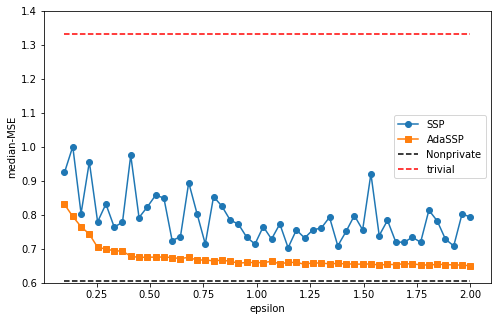

In [8]:
# Let's also plot the median
import matplotlib.pyplot as plt
#%matplotlib inline 
plt.figure(figsize=(8, 5))
plt.plot(eps_budget_list,med_MSE_list[:,0],'o-')
plt.plot(eps_budget_list,med_MSE_list[:,1],'s-')
plt.plot(eps_budget_list,MSE_nonprivate*np.ones(shape=(num,1)),'k--')
plt.plot(eps_budget_list,MSE_trivial*np.ones(shape=(num,1)),'r--')
plt.ylim([0.6,1.4])

plt.legend(['SSP','AdaSSP','Nonprivate','trivial'])
plt.xlabel('epsilon')
plt.ylabel('median-MSE')
plt.show()

As we can see the privacy utility tradeoff from the figure and that even with very strong privacy parameter ($\epsilon<1$) we can get high utility in the prediction of the privately fitted linear model.